In [ ]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Data Cleanup


In [ ]:
import pandas as pd

df = pd.read_csv('dataset_is.csv')
df = df[df['Brand']=="NUNA"].reset_index(drop=True)
df.head()

,Brand,Net Income,Ordinary Income,Gross Income,Line Items Layer 1,Line Items Layer 2,Line Items Layer 3,Line Items Layer 4,Line Items Layer 5,Month,Value
0,NUNA,Net Income,Ordinary Income,Gross Profit,Cost of Goods Sold,Cost of Goods Sold,Packaging Costs,(blank),(blank),12/1/24,-2625.65
1,NUNA,Net Income,Ordinary Income,Gross Profit,Cost of Goods Sold,Cost of Goods Sold,Packaging Costs,(blank),(blank),11/1/24,0.00
2,NUNA,Net Income,Ordinary Income,Gross Profit,Cost of Goods Sold,Cost of Goods Sold,Packaging Costs,(blank),(blank),10/1/24,-2120.44
3,NUNA,Net Income,Ordinary Income,Gross Profit,Cost of Goods Sold,Cost of Goods Sold,Packaging Costs,(blank),(blank),9/1/24,-2358.85
4,NUNA,Net Income,Ordinary Income,Gross Profit,Cost of Goods Sold,Cost of Goods Sold,Packaging Costs,(blank),(blank),8/1/24,0.00


In [ ]:
columns = ["Promotional_Event_Fees", "Business_Gifts","Airfare",
           "Marketing_POS_Swags_Banners","Freight_Product_Samples",
           "Marketing_Demo_Supplies","Sample_Inventory_Costs",
           "Samples_Handling_Fee","Marketing_Social_Media",
           "Website_Costs","Promotion","Ads_Bulletin", "Advertising",
           "Deduction_Payback","New_Item_Set_up","Other_MCB","Pass_through_Retail",
           "Price_Billing_Adjustment","Promotion","Short_Code","Velocity","Chargebacks_Other","Early_Pay_Discount",
           "Marketing_Allowance","Other_Allowance","Spoils","Returns_Allowances_Other",
           "Sales"
]


df = df.replace({
    "Ads/Ad Bulletin": "Ads Bulletin",
    })

df["Line Items Layer 1"] = df["Line Items Layer 1"].str.replace(r"[\-\s\,\/\&]", "", regex=True)
df["Line Items Layer 2"] = df["Line Items Layer 2"].str.replace(r"[\-\s\,\/\&]", "", regex=True)
df["Line Items Layer 3"] = df["Line Items Layer 3"].str.replace(r"[\-\s\,\/\&]", "", regex=True)
df["Line Items Layer 4"] = df["Line Items Layer 4"].str.replace(r"[\-\s\,\/\&]", "", regex=True)
df["Line Items Layer 5"] = df["Line Items Layer 5"].str.replace(r"[\-\s\,\/\&]", "", regex=True)


caught = False
columns_normal = [s.replace("_", "") for s in columns]
for idx, c in enumerate(columns_normal):
  caught = False

  for i in [1,2,3,4,5]:
    if c in df[f"Line Items Layer {i}"].values:
      df[f"Line Items Layer {i}"] = df[f"Line Items Layer {i}"].str.replace(c, columns[idx])
      print(c , columns[idx], f"Line Items Layer {i}")
      caught = True
  if not caught:
    print(f"No match for {c}")

PromotionalEventFees Promotional_Event_Fees Line Items Layer 3
BusinessGifts Business_Gifts Line Items Layer 3
Airfare Airfare Line Items Layer 3
MarketingPOSSwagsBanners Marketing_POS_Swags_Banners Line Items Layer 3
FreightProductSamples Freight_Product_Samples Line Items Layer 3
MarketingDemoSupplies Marketing_Demo_Supplies Line Items Layer 3
SampleInventoryCosts Sample_Inventory_Costs Line Items Layer 3
SamplesHandlingFee Samples_Handling_Fee Line Items Layer 4
MarketingSocialMedia Marketing_Social_Media Line Items Layer 3
WebsiteCosts Website_Costs Line Items Layer 3
Promotion Promotion Line Items Layer 4
AdsBulletin Ads_Bulletin Line Items Layer 4
Advertising Advertising Line Items Layer 3
DeductionPayback Deduction_Payback Line Items Layer 4
NewItemSetup New_Item_Set_up Line Items Layer 4
OtherMCB Other_MCB Line Items Layer 4
PassthroughRetail Pass_through_Retail Line Items Layer 4
PriceBillingAdjustment Price_Billing_Adjustment Line Items Layer 4
Promotion Promotion Line Items 

In [ ]:
data = pd.DataFrame(index=df["Month"].unique())

In [ ]:
for col in columns:
  if col in data.columns:
    continue
  if col in df["Line Items Layer 3"].values:
    x = "Line Items Layer 3"
  elif col in df["Line Items Layer 4"].values:
    x = "Line Items Layer 4"
  elif col in df["Line Items Layer 2"].values:
    x = "Line Items Layer 2"
  else:
    x = "Line Items Layer 1"
  temp = df[df[x]==col][["Month","Value"]].copy().reset_index(drop=True)
  temp.set_index("Month", inplace=True)
  temp.columns = [col]
  data[col] = temp[col]

# Marketing Expenses Vs Net Profit

Model Explanation -
In this analysis, I structured the company's marketing spend into logical categories to better understand its relationship with profitability. I first aggregated granular expense items into broader groups, such as:

1.**Marketing Events Total**:
Covers experiential and in-person promotional spend such as event fees, gifts, travel, and physical promotional materials (POS banners, swags).

2.**Marketing Samples Total**:
Represents costs tied to distributing product samples, including freight, demo supplies, sample inventory, and handling charges — essentially, spend to drive product trial.

3.**Marketing Social Total**:
Captures digital presence and owned media costs, specifically social media marketing and website maintenance.

4.**Marketing Broad Total**:
A comprehensive view of marketing investment that combines advertising, events, samples, and social, while also including sales-deduction style items like promotions and bulletin ads.

5.**Marketing Narrow Total**:
A stricter expense - only perspective, limited to advertising, events, samples, and social — excludes promotional discounts and bulletin ads to reflect pure marketing outlays.


and then combined them into broad and narrow marketing totals depending on whether sales deductions like promotions were included. Next, I incorporated the company's net profit data and calculated **spend ratios** **(each channel’s spend as a share of sales)**, allowing for a normalized view of marketing intensity.

Finally, I ran a series of linear regressions where net profit was modeled against each marketing channel (controlling for time with month and year), extracting the slope (magnitude of impact), intercept, and R² (goodness of fit).

This produced a comparative table of marketing drivers, highlighting which categories correlate most strongly - positively or negatively - with net profit and how influential each type of spending is.

In [ ]:
# Deep Dive into Marketing expenses
# Narrow "events/promo" type spend
data["Marketing_Events_Total"] = (
    data["Promotional_Event_Fees"]
    + data["Business_Gifts"]
    + data["Airfare"]
    + data["Marketing_POS_Swags_Banners"]
)

# Sampling-related spend
data["Marketing_Samples_Total"] = (
    data["Freight_Product_Samples"]
    + data["Marketing_Demo_Supplies"]
    + data["Sample_Inventory_Costs"]
    + data["Samples_Handling_Fee"]
)

# Digital/social/owned media
data["Marketing_Social_Total"] = (
    data["Marketing_Social_Media"]
    + data["Website_Costs"]
)

# Broad marketing investment : include sales-deduction style items
data["Marketing_Broad_Total"] = (
    data["Advertising"]
    + data["Marketing_Events_Total"]
    + data["Marketing_Samples_Total"]
    + data["Marketing_Social_Total"]
    + data["Promotion"]        # optional: move to narrow if you treat as expense
    + data["Ads_Bulletin"]     # optional: same note
)

# stricter "narrow" total (pure expense view, no Sales deductions):
data["Marketing_Narrow_Total"] = (
    data["Advertising"]
    + data["Marketing_Events_Total"]
    + data["Marketing_Samples_Total"]
    + data["Marketing_Social_Total"]
)

In [ ]:
data["date"] = data.index
data["date"] = pd.to_datetime(data["date"])

data.sort_values(by="date", inplace=True)

/tmp/ipython-input-2964752983.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["date"] = pd.to_datetime(data["date"])


In [ ]:
data["Net_profit"]  = [-7265.99, -2721.88, -18304.63, 3165.48, -14961.07, 12501.13,
 -186.86, 3724.02, 11242.47, 10456.19, 10469.86, 4283.78,
 -132722.01, 825.44, 2240.87, -7401.49, -28404.85,
 7532.04, -6000.28, 2590.80, 9739.56, -5513.83, 5366.95,
 -7604.25, -562.55, 4497.72, 14837.89, 1680.00,
 -9480.76, -13370.38, 9090.97, 6238.33, 7449.32, 939.33,
 5106.95, -4433.24]

In [ ]:
data.head()

,Promotional_Event_Fees,Business_Gifts,Airfare,Marketing_POS_Swags_Banners,Freight_Product_Samples,Marketing_Demo_Supplies,Sample_Inventory_Costs,Samples_Handling_Fee,Marketing_Social_Media,Website_Costs,...,Spoils,Returns_Allowances_Other,Sales,Marketing_Events_Total,Marketing_Samples_Total,Marketing_Social_Total,Marketing_Broad_Total,Marketing_Narrow_Total,date,Net_profit
1/1/22,500.0,0.0,0.0,0.0,-2528.29,0.0,-207.14,0.0,0.0,0.0,...,-22.40,0.0,55636.76,500.0,-2735.43,0.0,-4144.71,-2235.43,2022-01-01,-7265.99
2/1/22,0.0,0.0,0.0,0.0,-853.10,0.0,-288.82,0.0,0.0,0.0,...,-1249.95,0.0,97246.33,0.0,-1141.92,0.0,-3465.88,-1141.92,2022-02-01,-2721.88
3/1/22,-3750.0,0.0,0.0,0.0,-1643.00,0.0,-240.93,0.0,0.0,0.0,...,-2302.11,0.0,114607.05,-3750.0,-1883.93,0.0,-5633.93,-5633.93,2022-03-01,-18304.63
4/1/22,0.0,0.0,0.0,0.0,-995.47,0.0,-580.70,0.0,0.0,0.0,...,-133.29,0.0,118675.37,0.0,-1576.17,0.0,-2045.93,-1576.17,2022-04-01,3165.48
5/1/22,0.0,0.0,0.0,0.0,-253.47,0.0,-107.34,0.0,0.0,0.0,...,-141.69,0.0,72399.44,0.0,-360.81,0.0,-2459.91,-360.81,2022-05-01,-14961.07


In [ ]:
data["month"] = pd.to_datetime(list(data.index)).month
data["year"] = pd.to_datetime(list(data.index)).year

/tmp/ipython-input-251392326.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["month"] = pd.to_datetime(list(data.index)).month
/tmp/ipython-input-251392326.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["year"] = pd.to_datetime(list(data.index)).year


In [ ]:
train = data.iloc[:-12]
test = data.iloc[-12:]

In [ ]:


# Choose which features to test:
channels_to_test = [
    # individual lines
    "Advertising",
    "Marketing_Social_Media",
    "Promotional_Event_Fees",
    "Business_Gifts",
    "Airfare",
    "Freight_Product_Samples",
    "Marketing_Demo_Supplies",
    "Sample_Inventory_Costs",
    "Samples_Handling_Fee",
    "Marketing_POS_Swags_Banners",
    "Website_Costs",
    "Promotion",
    "Ads_Bulletin",

    # totals
    "Marketing_Events_Total",
    "Marketing_Samples_Total",
    "Marketing_Social_Total",
    "Marketing_Narrow_Total",
    "Marketing_Broad_Total",

]

# OLS

Model Explanation -
In this step, I moved beyond testing channels individually and built a **multivariate regression model** where Net Profit is explained by the entire set of marketing features together, along with controls for month and year.

Using statsmodels.OLS, I fit an Ordinary Least Squares (OLS) regression, **which estimates how much each marketing expense category contributes to profit while holding the others constant**. **This approach allows to see not only the direction and size of each channel’s effect but also whether certain categories are redundant or overshadowed by others when combined**.

The model outputs include key diagnostics such as coefficients (marginal impact of each feature), R² (overall explanatory power), standard errors (uncertainty in estimates), and significance levels (p-values to test statistical strength). In essence, this combined model provides a holistic view of how marketing channels jointly drive profit, revealing the most meaningful predictors once all factors are considered together.

In [ ]:
X = train[channels_to_test + ["month", "year"]]
Y = train["Net_profit"]
# Fill NaN values with 0, assuming NaN means no expense for these columns
X = X.fillna(0)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Net_profit   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.876
Method:                 Least Squares   F-statistic:                              19.84
Date:                Wed, 19 Nov 2025   Prob (F-statistic):                    8.92e-07
Time:                        23:21:00   Log-Likelihood:                         -249.83
No. Observations:                  24   AIC:                                      517.7
Df Residuals:                      15   BIC:                                      528.3
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Advertising                    66.2934      6.199     10.695      0.000      53.081      79.506
Marketing_Social_Media        -14.0962      5.184     -2.719      0.016     -25.146      -3.046
Promotional_Event_Fees        -12.7009      2.031     -6.252      0.000     -17.031      -8.371
Business_Gifts               1.664e-11   8.32e-12      2.000      0.064   -1.09e-12    3.44e-11
Airfare                     -1.615e-12   8.07e-13     -2.002      0.064   -3.33e-12    1.04e-13
Freight_Product_Samples       -10.0581      6.135     -1.639      0.122     -23.135       3.019
Marketing_Demo_Supplies     -3.359e-12   1.68e-12     -1.998      0.064   -6.94e-12    2.24e-13
Sample_Inventory_Costs         -8.1327      6.861     -1.185      0.254     -22.757       6.492
Samples_Handling_Fee        -2.775e-15   1.29e-15     -2.147      0.049   -5.53e-15   -2.03e-17
Marketing_POS_Swags_Banners          0          0        nan        nan           0           0
Website_Costs                        0          0        nan        nan           0           0
Promotion                      -6.9542      2.476     -2.809      0.013     -12.231      -1.677
Ads_Bulletin                   -8.9615      3.810     -2.352      0.033     -17.083      -0.840
Marketing_Events_Total        -12.7009      2.031     -6.252      0.000     -17.031      -8.371
Marketing_Samples_Total       -18.1908      2.370     -7.677      0.000     -23.242     -13.140
Marketing_Social_Total        -14.0962      5.184     -2.719      0.016     -25.146      -3.046
Marketing_Narrow_Total         21.3055      3.497      6.093      0.000      13.853      28.758
Marketing_Broad_Total           5.3899      1.370      3.935      0.001       2.470       8.310
month                        1584.3840    792.145      2.000      0.064    -104.034    3272.802
year                           -6.3234      3.545     -1.784      0.095     -13.879       1.233
==============================================================================
Omnibus:                        9.232   Durbin-Watson:                   2.607
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                7.088
Skew:                          -1.180   Prob(JB):                       0.0289
Kurtosis:                       4.230   Cond. No.                     7.81e+32
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.51e-57. This might indicate that there are
strong multicollinearity proble

In [ ]:
# ===========================================
#  Significant Marketing Levers (Sponsor-Ready)
# ===========================================
import pandas as pd
import numpy as np

ALPHA = 0.10
IGNORE_COLS = {"const", "intercept", "_cons", "month", "year"}

out = pd.DataFrame({
    "coef": results.params,
    "std_err": results.bse,
    "t": results.tvalues,
    "p": results.pvalues
})
ci = results.conf_int()
out["ci_low"] = ci[0]
out["ci_high"] = ci[1]

# Keep only business levers
lever_mask = ~out.index.str.lower().isin(IGNORE_COLS)
levers = out[lever_mask].sort_values("p")

# Categorize
sig_pos = levers[(levers["p"] < ALPHA) & (levers["coef"] > 0)]
sig_neg = levers[(levers["p"] < ALPHA) & (levers["coef"] < 0)]
neutral = levers[levers["p"] >= ALPHA]

# Print summary
print("═══════════════════════════════════════════════════")
print(" Significant Marketing Levers (p < 0.1)")

# Positive
print("\n Positive (increase spend → ↑ Net Profit):")
if len(sig_pos):
    for name, r in sig_pos.iterrows():
        print(f"  • {name}: β=+{r.coef:.3f}, p={r.p:.4f}, CI[{r.ci_low:.3f}, {r.ci_high:.3f}]")
else:
    print("  • None detected.")

# Negative
print("\n Negative (increase spend → ↓ Net Profit):")
if len(sig_neg):
    for name, r in sig_neg.iterrows():
        print(f"  • {name}: β={r.coef:.3f}, p={r.p:.4f}, CI[{r.ci_low:.3f}, {r.ci_high:.3f}]")
else:
    print("  • None detected.")

# Neutral
print("\n Neutral Levers (p ≥ 0.05): {} levers".format(len(neutral)))
if len(neutral):
    for name, r in neutral.iterrows():
        print(f"  • {name}: β={r.coef:.3f}, p={r.p:.4f}")
    print("  → No statistically meaningful impact detected on Net Profit.")
else:
    print("  • None.")

print("═══════════════════════════════════════════════════")

# Optional: export for documentation or dashboard
lever_report = levers.assign(direction=np.where(levers["coef"]>0,"positive","negative"))
lever_report.to_csv("lever_significance_report.csv", index=True)


═══════════════════════════════════════════════════
 Significant Marketing Levers (p < 0.1)

 Positive (increase spend → ↑ Net Profit):
  • Advertising: β=+66.293, p=0.0000, CI[53.081, 79.506]
  • Marketing_Narrow_Total: β=+21.305, p=0.0000, CI[13.853, 28.758]
  • Marketing_Broad_Total: β=+5.390, p=0.0013, CI[2.470, 8.310]
  • Business_Gifts: β=+0.000, p=0.0639, CI[-0.000, 0.000]

 Negative (increase spend → ↓ Net Profit):
  • Marketing_Samples_Total: β=-18.191, p=0.0000, CI[-23.242, -13.140]
  • Marketing_Events_Total: β=-12.701, p=0.0000, CI[-17.031, -8.371]
  • Promotional_Event_Fees: β=-12.701, p=0.0000, CI[-17.031, -8.371]
  • Promotion: β=-6.954, p=0.0132, CI[-12.231, -1.677]
  • Marketing_Social_Media: β=-14.096, p=0.0158, CI[-25.146, -3.046]
  • Marketing_Social_Total: β=-14.096, p=0.0158, CI[-25.146, -3.046]
  • Ads_Bulletin: β=-8.961, p=0.0328, CI[-17.083, -0.840]
  • Samples_Handling_Fee: β=-0.000, p=0.0485, CI[-0.000, -0.000]
  • Airfare: β=-0.000, p=0.0637, CI[-0.000, 0.00

## Model On train Dataset

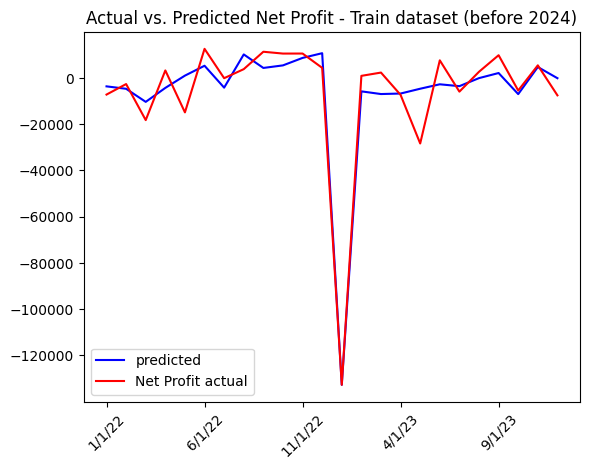

In [ ]:
results.predict(X).plot(kind="line", rot=45, label="predicted", color = "blue")
Y.plot(kind="line", rot=45, label = "Net Profit actual", color = "red")
plt.title("Actual vs. Predicted Net Profit - Train dataset (before 2024)")
plt.legend()
plt.show()

### Model on test dataset

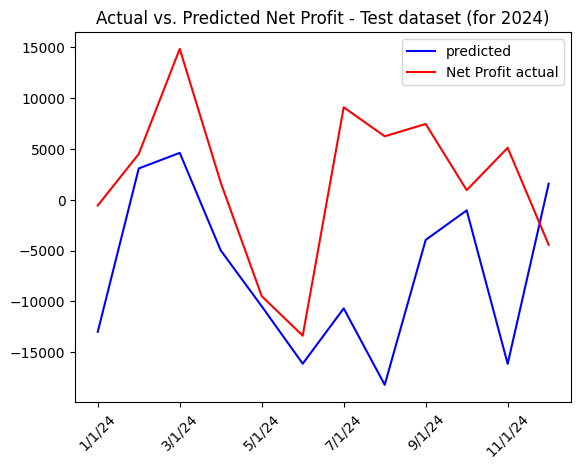

In [ ]:
X_test = test[channels_to_test + ["month", "year"]]
Y_test = test["Net_profit"]
results.predict(X_test.fillna(0)).sort_index().plot(kind="line", rot=45, label="predicted", color = "blue")
Y_test.plot(kind="line", rot=45, label = "Net Profit actual", color = "red")
plt.title("Actual vs. Predicted Net Profit - Test dataset (for 2024)")
plt.legend()
plt.show()

In [ ]:
delta_2023_2022 = X[X["year"]==2023].reset_index(drop=True) - X[X["year"]==2022].reset_index(drop=True)
delta_2024_2023 = X_test.reset_index(drop=True) - X[X["year"]==2023].reset_index(drop=True)

delta = (0.2*(delta_2023_2022)+0.8*(delta_2024_2023))

delta

,Advertising,Marketing_Social_Media,Promotional_Event_Fees,Business_Gifts,Airfare,Freight_Product_Samples,Marketing_Demo_Supplies,Sample_Inventory_Costs,Samples_Handling_Fee,Marketing_POS_Swags_Banners,Website_Costs,Promotion,Ads_Bulletin,Marketing_Events_Total,Marketing_Samples_Total,Marketing_Social_Total,Marketing_Narrow_Total,Marketing_Broad_Total,month,year
0,811.842,0.000,-100.000,0.00,0.000,1002.610,0.000,-243.308,-160.0,0.00,0.0,381.856,494.64,-100.000,599.302,0.000,1311.144,2187.640,0.0,1.0
1,0.000,0.000,0.000,0.00,0.000,296.026,0.000,148.250,-80.0,0.00,0.0,464.792,584.28,0.000,364.276,0.000,364.276,1413.348,0.0,1.0
2,0.000,69.492,750.000,0.00,0.000,631.268,-601.496,15.704,-160.0,0.00,0.0,0.000,0.00,750.000,-114.524,69.492,704.968,704.968,0.0,1.0
3,0.000,144.780,1450.000,0.00,0.000,512.642,-100.168,-116.338,-160.0,0.00,0.0,93.952,570.00,1450.000,136.136,144.780,1730.916,2394.868,0.0,1.0
4,0.000,0.000,-2800.000,0.00,-323.496,-88.776,0.000,44.388,-400.0,-101.04,0.0,205.500,-345.68,-3224.536,-444.388,0.000,-3668.924,-3809.104,0.0,1.0
5,0.000,0.000,0.000,0.00,0.000,423.696,0.000,391.344,-80.0,0.00,0.0,0.000,365.04,0.000,735.040,0.000,735.040,1100.080,0.0,1.0
6,0.000,0.000,2116.576,0.00,0.000,-97.508,0.000,-659.276,0.0,0.00,0.0,282.720,0.00,2116.576,-756.784,0.000,1359.792,1642.512,0.0,1.0
7,0.000,134.574,0.000,0.00,0.000,157.484,-48.000,33.442,0.0,-359.20,-600.0,190.024,308.88,-359.200,142.926,-465.426,-681.700,-182.796,0.0,1.0
8,0.000,0.000,828.350,0.00,0.000,164.250,0.000,67.020,0.0,0.00,0.0,334.086,315.36,828.350,231.270,0.000,1059.620,1709.066,0.0,1.0
9,0.000,0.000,4830.000,0.00,0.000,257.702,0.000,176.820,0.0,0.00,0.0,175.016,0.00,4830.000,434.522,0.000,5264.522,5439.538,0.0,1.0


In [ ]:
future = X_test.reset_index(drop=True)+delta
future["predicted"] = results.predict(future.fillna(0))
future["prev_1_year"] = test["Net_profit"].values
# create date column from year and month column
future = future.set_index((pd.to_datetime(future["year"].astype(int).astype(str) + \
                                "-" + future["month"].astype(int).astype(str) + "-01")))
future

,Advertising,Marketing_Social_Media,Promotional_Event_Fees,Business_Gifts,Airfare,Freight_Product_Samples,Marketing_Demo_Supplies,Sample_Inventory_Costs,Samples_Handling_Fee,Marketing_POS_Swags_Banners,...,Ads_Bulletin,Marketing_Events_Total,Marketing_Samples_Total,Marketing_Social_Total,Marketing_Narrow_Total,Marketing_Broad_Total,month,year,predicted,prev_1_year
2025-01-01,811.842,0.000,-100.000,0.00,0.000,934.730,0.000,-731.558,-360.0,0.00,...,494.64,-100.000,-156.828,0.000,555.014,1431.510,1.0,2025.0,56992.539668,-562.55
2025-02-01,0.000,0.000,0.000,0.00,0.000,296.026,0.000,148.250,-180.0,0.00,...,584.28,0.000,264.276,0.000,264.276,1313.348,2.0,2025.0,-14385.547112,4497.72
2025-03-01,0.000,69.492,750.000,0.00,0.000,592.858,-1353.366,-101.226,-360.0,0.00,...,0.00,750.000,-1221.734,69.492,-402.242,-402.242,3.0,2025.0,-22715.751080,14837.89
2025-04-01,0.000,144.330,450.000,0.00,0.000,512.642,-225.378,-565.118,-360.0,0.00,...,570.00,450.000,-637.854,144.330,-43.524,620.428,4.0,2025.0,-14269.040428,1680.00
2025-05-01,0.000,0.000,-6300.000,0.00,-727.866,-362.706,0.000,-79.782,-900.0,-227.34,...,-1045.68,-7255.206,-1342.488,0.000,-8597.694,-9437.874,5.0,2025.0,-30106.368184,-9480.76
2025-06-01,0.000,0.000,0.000,0.00,0.000,291.096,0.000,354.944,-180.0,0.00,...,365.04,0.000,466.040,0.000,466.040,831.080,6.0,2025.0,-6453.390503,-13370.38
2025-07-01,0.000,0.000,2116.576,0.00,0.000,-733.488,0.000,-1538.346,0.0,0.00,...,0.00,2116.576,-2271.834,0.000,-155.258,127.462,7.0,2025.0,1148.708946,9090.97
2025-08-01,0.000,134.574,0.000,0.00,0.000,-6.416,-108.000,-35.588,0.0,-808.20,...,308.88,-808.200,-150.004,-1215.426,-2173.630,-1674.726,8.0,2025.0,-30972.670719,6238.33
2025-09-01,0.000,0.000,828.350,0.00,0.000,73.140,0.000,-2.350,0.0,0.00,...,315.36,828.350,70.790,0.000,899.140,1548.586,9.0,2025.0,762.590821,7449.32
2025-10-01,0.000,0.000,4830.000,0.00,0.000,238.152,0.000,176.820,0.0,0.00,...,0.00,4830.000,414.972,0.000,5244.972,5419.988,10.0,2025.0,8708.408995,939.33


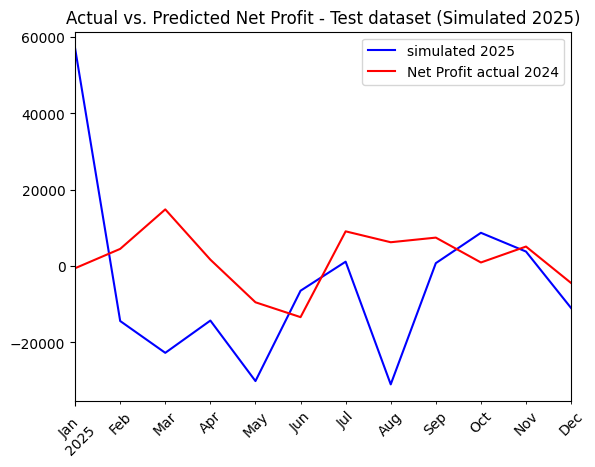

In [ ]:
future["predicted"].sort_index().plot(kind="line", rot=45, label="simulated 2025", color = "blue")
future["prev_1_year"].plot(kind="line", rot=45, label = "Net Profit actual 2024", color = "red")
plt.title("Actual vs. Predicted Net Profit - Test dataset (Simulated 2025)")
plt.legend()
plt.show()

In [ ]:
#Train RMSE
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(Y, results.predict(X)))
print(f"RMSE: {rmse}")

RMSE: 8027.723942663448


In [ ]:
#Test RMSE

from sklearn.metrics import mean_squared_error
import math

# rmse = math.sqrt(mean_squared_error(Y_test, results.predict(X_test)))
# print(f"RMSE: {rmse}")

# Trade Spend VS Net Profit

Model Explanation -
In this step, I shifted focus from marketing spend to trade spend components - items such as allowances, promotions, deductions, chargebacks, and discounts that directly affect the company’s net revenue and profit. I first selected a group of relevant trade-related expense and adjustment variables (e.g., promotions, price/billing adjustments, returns, allowances, early pay discounts). Then, using the same regression approach as before, I ran a series of simple linear regressions where Net Profit was modeled against each trade component individually, while controlling for time effects (month and year).

The output of this process gives three key statistics for each trade component:

1. Slope (magnitude of effect): How strongly that trade component influences profit — positive slopes imply profit rises as that component increases, while negative slopes indicate a drag on profit.

2. R² (normalized correlation): How much variation in profit is explained by that component alone.

3. Intercept: Baseline profit level when that component is zero.

This analysis helps identify **which trade spend levers are most correlated with net profit and whether they tend to enhance or erode profitability.** Compared with the marketing model, this provides a complementary view - showing how discounts, returns, and trade allowances shape short-term margins, alongside the promotional investments tracked in marketing spend

In [ ]:
trade_component_cols = [
    "Ads_Bulletin",
    "Deduction_Payback",
    "New_Item_Set_up",
    "Other_MCB",
    "Pass_through_Retail",
    "Price_Billing_Adjustment",
    "Promotion",
    "Short_Code",
    "Velocity",
    "Chargebacks_Other",
    "Early_Pay_Discount",
    "Marketing_Allowance",
    "Other_Allowance",
    "Spoils",
    "Returns_Allowances_Other"
]

trade_component_cols = [col for col in trade_component_cols if col in data.columns]


# OLS

Model Explanation-
In this step, I expanded from individual regressions to a multivariate OLS regression where all trade spend components are modeled together against net profit, while also controlling for month and year effects. By fitting this model, I captured the simultaneous influence of multiple trade levers — such as promotions, billing adjustments, allowances, discounts, and chargebacks — on profitability.

This gives a **holistic view of how the trade structure as a whole interacts with net profit.** This allows to identify the dominant drivers (e.g., which allowances or promotions significantly erode margins) and the supportive mechanisms (like billing adjustments or chargeback recoveries) that improve financial outcomes, while filtering out redundant signals caused by overlapping trade spend categories.



In [ ]:
# combined model

X = train[trade_component_cols + ["month", "year"]]
Y = train["Net_profit"]
X = X.fillna(0)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Net_profit   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.702
Method:                 Least Squares   F-statistic:                              4.323
Date:                Wed, 19 Nov 2025   Prob (F-statistic):                      0.0282
Time:                        23:21:02   Log-Likelihood:                         -251.21
No. Observations:                  24   AIC:                                      536.4
Df Residuals:                       7   BIC:                                      556.5
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Ads_Bulletin                -8.2355      7.937     -1.038      0.334     -27.004      10.533
Deduction_Payback            4.2046     13.795      0.305      0.769     -28.416      36.826
New_Item_Set_up            -35.3625     69.123     -0.512      0.625    -198.812     128.087
Other_MCB                    1.5886      1.847      0.860      0.418      -2.780       5.957
Pass_through_Retail         89.9677    167.137      0.538      0.607    -305.249     485.184
Price_Billing_Adjustment     0.6005      8.094      0.074      0.943     -18.539      19.740
Promotion                    1.1448      7.798      0.147      0.887     -17.293      19.583
Short_Code                 -21.0380     74.246     -0.283      0.785    -196.601     154.525
Velocity                    -9.1347     54.978     -0.166      0.873    -139.138     120.868
Chargebacks_Other            8.5204      1.499      5.684      0.001       4.976      12.065
Early_Pay_Discount          -8.9600     12.026     -0.745      0.481     -37.398      19.478
Marketing_Allowance         84.8192    105.382      0.805      0.447    -164.369     334.007
Other_Allowance              5.2601      1.190      4.420      0.003       2.446       8.074
Spoils                      -7.9889     11.976     -0.667      0.526     -36.308      20.330
Returns_Allowances_Other     5.9473      1.060      5.612      0.001       3.442       8.453
month                     2211.5613   1878.236      1.177      0.277   -2229.762    6652.884
year                         1.4746      8.949      0.165      0.874     -19.687      22.637
==============================================================================
Omnibus:                        0.599   Durbin-Watson:                   2.543
Prob(Omnibus):                  0.741   Jarque-Bera (JB):                0.291
Skew:                           0.266   Prob(JB):                        0.865
Kurtosis:                       2.909   Cond. No.                     6.54e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# ===========================================
# Significant Trade Spend Levers (Sponsor-Ready)
# ===========================================
import pandas as pd
import numpy as np

ALPHA = 0.1
IGNORE_COLS = {"const", "intercept", "_cons", "month", "year"}

out = pd.DataFrame({
    "coef": results.params,
    "std_err": results.bse,
    "t": results.tvalues,
    "p": results.pvalues
})
ci = results.conf_int()
out["ci_low"] = ci[0]
out["ci_high"] = ci[1]

# Keep only business levers
lever_mask = ~out.index.str.lower().isin(IGNORE_COLS)
levers = out[lever_mask].sort_values("p")

# Categorize
sig_pos = levers[(levers["p"] < ALPHA) & (levers["coef"] > 0)]
sig_neg = levers[(levers["p"] < ALPHA) & (levers["coef"] < 0)]
neutral = levers[levers["p"] >= ALPHA]

# Print summary
print("═══════════════════════════════════════════════════")
print("Significant Trade Spend Levers (p < 0.1)")

# Positive
print("\n Positive (increase spend → ↑ Net Profit):")
if len(sig_pos):
    for name, r in sig_pos.iterrows():
        print(f"  • {name}: β=+{r.coef:.3f}, p={r.p:.4f}, CI[{r.ci_low:.3f}, {r.ci_high:.3f}]")
else:
    print("  • None detected.")

# Negative
print("\n Negative (increase spend → ↓ Net Profit):")
if len(sig_neg):
    for name, r in sig_neg.iterrows():
        print(f"  • {name}: β={r.coef:.3f}, p={r.p:.4f}, CI[{r.ci_low:.3f}, {r.ci_high:.3f}]")
else:
    print("  • None detected.")

# Neutral
print("\n Neutral Levers (p ≥ 0.05): {} levers".format(len(neutral)))
if len(neutral):
    for name, r in neutral.iterrows():
        print(f"  • {name}: β={r.coef:.3f}, p={r.p:.4f}")
    print("  → No statistically meaningful impact detected on Net Profit.")
else:
    print("  • None.")

print("═══════════════════════════════════════════════════")

# Optional: export for documentation or dashboard
lever_report = levers.assign(direction=np.where(levers["coef"]>0,"positive","negative"))
lever_report.to_csv("lever_significance_report.csv", index=True)



═══════════════════════════════════════════════════
Significant Trade Spend Levers (p < 0.1)

 Positive (increase spend → ↑ Net Profit):
  • Chargebacks_Other: β=+8.520, p=0.0007, CI[4.976, 12.065]
  • Returns_Allowances_Other: β=+5.947, p=0.0008, CI[3.442, 8.453]
  • Other_Allowance: β=+5.260, p=0.0031, CI[2.446, 8.074]

 Negative (increase spend → ↓ Net Profit):
  • None detected.

 Neutral Levers (p ≥ 0.05): 12 levers
  • Ads_Bulletin: β=-8.236, p=0.3340
  • Other_MCB: β=1.589, p=0.4183
  • Marketing_Allowance: β=84.819, p=0.4474
  • Early_Pay_Discount: β=-8.960, p=0.4805
  • Spoils: β=-7.989, p=0.5261
  • Pass_through_Retail: β=89.968, p=0.6071
  • New_Item_Set_up: β=-35.363, p=0.6247
  • Deduction_Payback: β=4.205, p=0.7694
  • Short_Code: β=-21.038, p=0.7851
  • Velocity: β=-9.135, p=0.8727
  • Promotion: β=1.145, p=0.8874
  • Price_Billing_Adjustment: β=0.601, p=0.9429
  → No statistically meaningful impact detected on Net Profit.
════════════════════════════════════════════════

## Guideline for understanding the model output (for business insights) -
####1. RMSE -
A lower RMSE value indicates higher model accuracy (the forecasts are closer to actual results).
A higher RMSE suggests that the model’s predictions deviate more from reality and may require adjustments (e.g., rechecking feature inputs or training period).

**Business Use:** RMSE helps assess how reliable the forecast is for decision-making. For example, if RMSE = 10,000, it means the forecasted monthly Net Profit may vary by ±$10,000 from the actual expected value.

#### 2. Coefficients (β-values) -
Positive Coefficient (β > 0): Spending more in this category is associated with higher Net Profit (e.g., Advertising, Events).
Negative Coefficient (β < 0): Spending more in this category is linked to lower Net Profit, indicating overspending or inefficient ROI (e.g., Trade Deductions, Sampling).

**Business Use:** Coefficients help identify which marketing or trade activities contribute most effectively to profitability, guiding budget allocation decisions.

#### 3.Standard Error (SE) -
A small Standard Error means the model has estimated the coefficient with high confidence - the variable’s effect on Net Profit is stable and consistent across the dataset.
A large Standard Error means the estimate is uncertain - the variable’s relationship with Net Profit fluctuates across months or is influenced by other unaccounted factors.


**Business Use:**
When comparing marketing or trade channels, prioritize those with low standard errors, as they provide more reliable relationships with profit.
For instance, if Advertising has a low SE, you can be more confident that its positive impact on Net Profit is consistent over time.
Conversely, a high SE in Social Media Spend would suggest its ROI varies month to month, requiring closer monitoring or further segmentation.

#### 4.t-Value (t-Statistic)
A high absolute t-value (typically greater than ±2) indicates that the variable has a strong and statistically significant effect on Net Profit. A low t-value (close to 0) means the variable has little or no measurable influence on the outcome.
The sign of the t-value (positive or negative) matches the direction of the coefficient — whether the variable increases or decreases profit.


**Business Use:**
A high positive t-value for Advertising Spend means that higher advertising investment strongly drives profit growth.
A high negative t-value for Trade Deductions means increased deductions significantly reduce profit margins.
A low t-value for a variable like Social Media Spend suggests the effect on profit is weak or inconsistent and may not justify further investment without additional evidence.



#### 5. P-Value (Statistical Significance) -
p < 0.05: The relationship is statistically significant - this factor meaningfully affects profit. p ≥ 0.05: The factor’s influence is not statistically strong enough to be certain.

**Business Use: **Focus on marketing or trade spend categories with low p-values -  these are proven, data-supported drivers of profitability.
Confidence Intervals (Upper & Lower Bounds) - The upper bound shows the most optimistic scenario (best case).The lower bound shows the most conservative scenario (worst case).
Business Use: This helps decision-makers understand risk. If forecasts show wide intervals, the business should plan for volatility or gather more data to improve model precision.

#### 6. Confidence Intervals (Upper & Lower Bounds) -
The upper bound shows the most optimistic scenario (best case).The lower bound shows the most conservative scenario (worst case).

**Business Use:** This helps decision-makers understand risk. If forecasts show wide intervals, the business should plan for volatility or gather more data to improve model precision.